In [1]:
import gpytorch
import linear_operator
from lodegp.LODEGP import LODEGP
import torch
from torch import pi
from matplotlib import pyplot as plt
from time import perf_counter

torch.set_default_dtype(torch.float64)
"""
System: Angular velocity of a permanent magnet synchronous motor
with the motor torque 3/4  * p * Phi * i_q(t) = tau(t)

J_m * omega'(t) + b_m * omega(t) - 3/4 * p * Phi * i_q(t) = 0
"""
sp = {"bm": float(0.08), "Jm": float(0.01), "p": float(8), "Phi": float(0.02)}
COUNT = int(2000)

In [2]:
START = float(0)
END = float(2)
train_x = torch.linspace(START, END, COUNT)
steps_s = COUNT / END

# generate input
cosine_interp = lambda x, y0, y1, a, b: y0 + (y1 - y0) * (float(1) - torch.cos(pi * (x-a)/(b-a))) / float(2)
omega = torch.zeros_like(train_x)
ramp = cosine_interp(train_x, float(0), float(100), float(0.1), float(0.9))
omega[int(0.1 * steps_s): int(0.9 * steps_s)] = ramp[int(0.1 * steps_s): int(0.9 * steps_s)]
omega[int(0.9 * steps_s): int(1.1 * steps_s)] = torch.full([int(0.2 * steps_s)], float(100))
ramp = cosine_interp(train_x, float(100), float(0), float(1.1), float(1.9))
omega[int(1.1 * steps_s): int(1.9 * steps_s)] = ramp[int(1.1 * steps_s): int(1.9 * steps_s)]


iq = torch.full([COUNT], torch.nan)
bm_c = sp["bm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
iq[:int(0.1 * steps_s)] = torch.zeros(int(0.1 * steps_s))
iq[int(0.9 * steps_s):int(1.1 * steps_s)] = torch.full([int(0.2 * steps_s)], bm_c * float(100))
iq[int(1.9 * steps_s):] = torch.zeros(int(0.1 * steps_s))

train_y = torch.stack([omega, iq], dim=int(-1))

# create target i_q
d_cos = lambda x, y0, y1, a, b: pi*(y1-y0)*torch.sin(pi*(x-a)/(b-a)) / (2*(b-a))
J_c = sp["Jm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
iq_target = torch.full([COUNT], torch.nan)
d_omega = d_cos(train_x, float(0), float(100), float(0.1), float(0.9))
ramp_up = J_c * d_omega + bm_c * omega
iq_target[int(0.1 * steps_s): int(0.9 * steps_s)] = ramp_up[int(0.1 * steps_s): int(0.9 * steps_s)]
d_omega = d_cos(train_x, float(100), float(0), float(1.1), float(1.9))
ramp_up = J_c * d_omega + bm_c * omega
iq_target[int(1.1 * steps_s): int(1.9 * steps_s)] = ramp_up[int(1.1 * steps_s): int(1.9 * steps_s)]

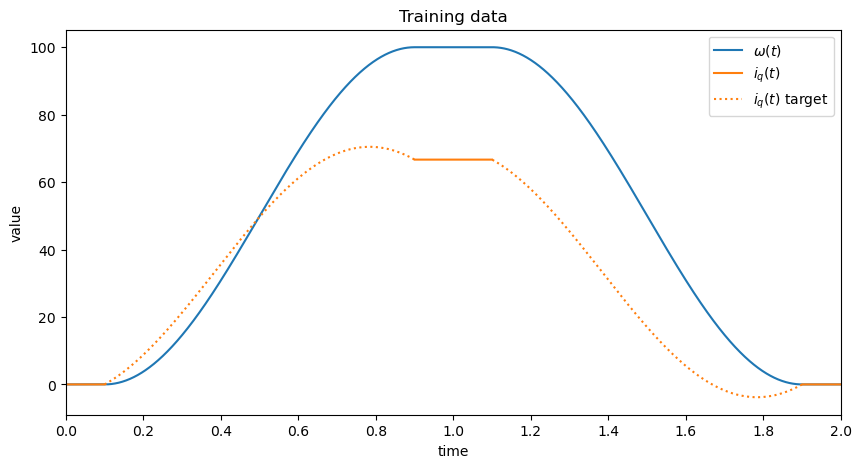

In [3]:
f = plt.figure(figsize=(int(10),int(5)))
plt.title("Training data")
plt.xlabel("time")
plt.ylabel("value")
plt.xlim(START, END)
plt.xticks(torch.arange(START, END+float(0.2), float(0.2)))
lines = plt.plot(train_x, train_y)
target_line = plt.plot(train_x, iq_target)
target_line[0].set_color(lines[1].get_color())
target_line[0].set_linestyle(":")
plt.legend(["$\\omega(t)$", "$i_q(t)$", "$i_q(t)$ target"])
plt.show()

In [4]:
# model definition
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=int(2))
model = LODEGP(
    train_x, train_y, likelihood, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    base_kernel="SE_kernel"
)
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.01))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    for i in range(int(100)):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    print(f"Training time: {perf_counter() - start_time:.2f}s")

# model definition
likelihood_approx = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=int(2))
model_approx = LODEGP(
    train_x, train_y, likelihood_approx, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    approx=True,
    number_of_eigenvalues=int(50),
    base_kernel="SE_kernel"
)
model_approx.train()
likelihood_approx.train()
optimizer_approx = torch.optim.Adam(model_approx.parameters(), lr=float(0.01))
mll_approx = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_approx, model_approx)

with gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    for i in range(int(100)):
        optimizer_approx.zero_grad()
        output = model_approx(train_x)
        loss = -mll_approx(output, train_y)
        loss.backward()
        optimizer_approx.step()
    print(f"Training time Approx: {perf_counter() - start_time:.2f}s")

Training time: 166.79s
Training time Approx: 34.57s


In [5]:
to_plot = dict()

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"):
    start_time = perf_counter()
    test_x = torch.linspace(START, END, COUNT//int(2) + int(1))
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    # compute confidence region
    # we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time: {perf_counter() - start_time:.2f}s")
    to_plot["mean"] = mean
    to_plot["lower"] = lower
    to_plot["upper"] = upper

model_approx.eval()
likelihood_approx.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    test_x = torch.linspace(START, END, COUNT//int(2) + int(1))
    predictions = likelihood_approx(model_approx(test_x))
    mean = predictions.mean
    # compute confidence region
    # (we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time Approximate: {perf_counter() - start_time:.2f}s")
    to_plot["mean_approx"] = mean
    to_plot["lower_approx"] = lower
    to_plot["upper_approx"] = upper

Eval time: 209.33s
Eval time Approximate: 61.53s


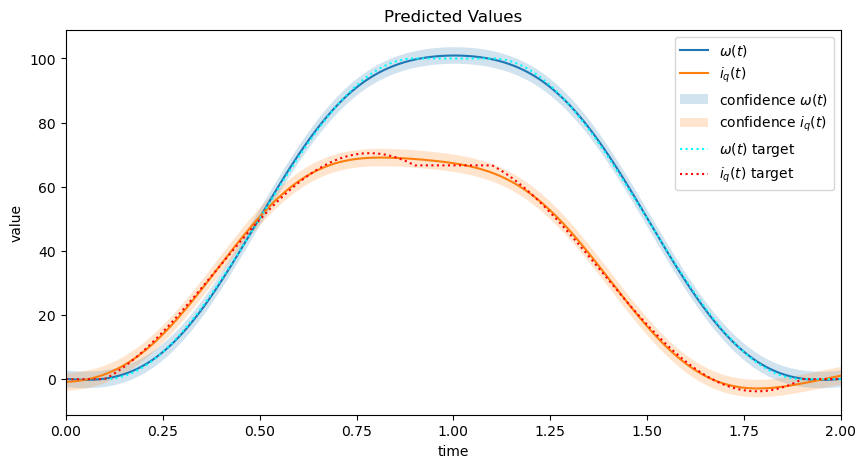

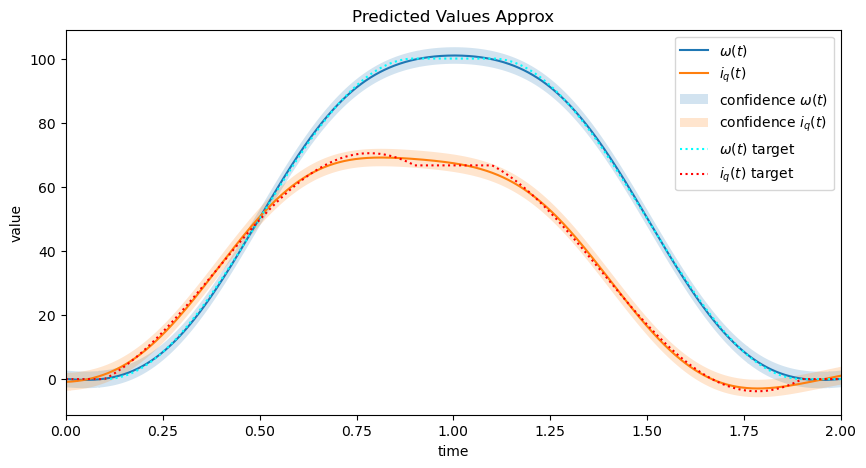

In [6]:
def plot(m, low, up, title):
    f = plt.figure(figsize=(int(10),int(5)))
    plt.title(title)
    plt.xlabel("time")
    plt.ylabel("value")
    plt.xlim(START, END)
    test_y = torch.stack([m[:, 0], m[:, 1]], dim=int(-1))
    plt.plot(test_x, test_y)
    plt.fill_between(test_x, low[:, 0], up[:, 0], alpha=0.2)
    plt.fill_between(test_x, low[:, 1], up[:, 1], alpha=0.2)
    target_line = plt.plot(train_x, omega)
    target_line[0].set_color("cyan")
    target_line[0].set_linestyle(":")
    target_line = plt.plot(train_x, iq_target.nan_to_num(float(0)) + iq.nan_to_num(float(0)))
    target_line[0].set_color("red")
    target_line[0].set_linestyle(":")
    plt.legend(["$\\omega(t)$", "$i_q(t)$", "confidence $\\omega(t)$", "confidence $i_q(t)$", "$\\omega(t)$ target", "$i_q(t)$ target"])

plot(to_plot["mean"], to_plot["lower"], to_plot["upper"], "Predicted Values")
plot(to_plot["mean_approx"], to_plot["lower_approx"], to_plot["upper_approx"], "Predicted Values Approx")